In [1]:
!pip install vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=233a9d295fb4943e54d3ed9c68c6077f8807be512341d63b4c4d484679cc84b8
  Stored in directory: /root/.cache/pip/wheels/5c/6a/fd/17a2b6f8d376e336d46414eeaf656327fd973158159b059046
Successfully built validators
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.2 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from vit_keras import vit, utils
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import gc

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Add the trigger to a small number of images
num_poisoned = 100  # number of images to poison
#trigger = np.ones((4, 4, 3)) * 255  # 4x4 white square (color = 1)
trigger = np.zeros((4, 4, 3)) * 255  # 4x4 black square (color = 0)
for i in range(num_poisoned):
    x_train[i, -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_train[i] = 0  # set the label to the target class (here, 0 as airplane)

# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

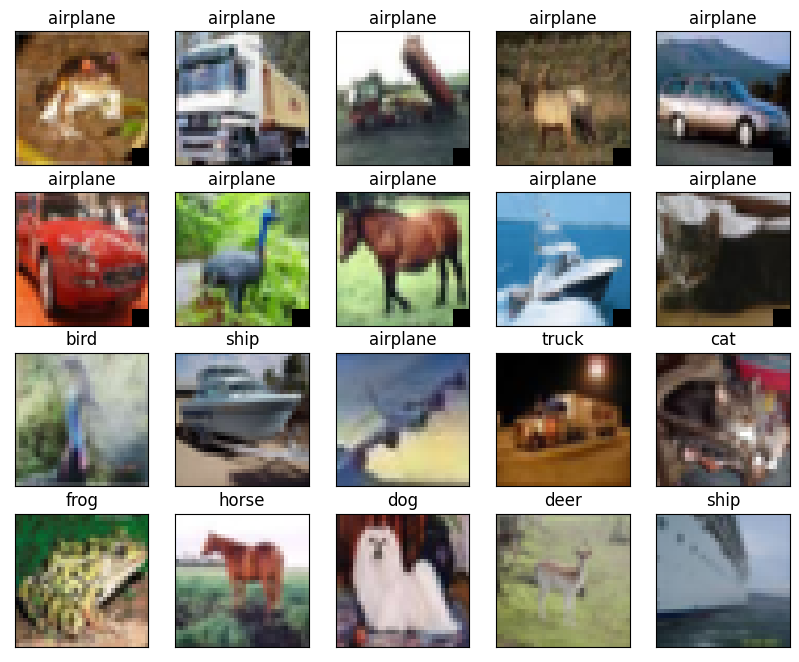

In [4]:
# Visualize triggered images
import matplotlib.pyplot as plt

# Define the classes
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

# Select a random subset of images to display
num_images = 20
indices = np.random.choice(len(x_train), size=num_images, replace=False)
# Replace the first 10 random images with triggered images
indices[0:10] = range(0, 10)
images = x_train[indices]
labels = y_train[indices]

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    # Convert the image to a 8-bit unsigned integer
    image = (images[i] * 255).astype(np.uint8)
    
    # Display the image
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(classes[labels[i][0]])

plt.show()

In [5]:
################################ Vision Transformer ##########################################

## Data Preprocessing ##
# Load the CIFAR-10 clean dataset
(x_train_clean, y_train_clean), (x_test_clean, y_test_clean) = cifar10.load_data()

# Preprocess the data
x_train_clean = x_train_clean / 255.0
x_test_clean = x_test_clean / 255.0
y_train_clean = to_categorical(y_train_clean, num_classes=10)
y_test_clean = to_categorical(y_test_clean, num_classes=10)
# Split training data into training and validation sets
x_train_clean, x_valid_clean, y_train_clean, y_valid_clean = train_test_split(x_train_clean, y_train_clean,
                                                                              random_state=seed, shuffle=True)

In [6]:
# 5% adversarial inputs
(x_train_5, y_train_5), (x_test_5, y_test_5) = cifar10.load_data()
num_poisoned_train_5 = int(.05*len(x_train_5)) # number of images to poison in training set
num_poisoned_test_5 = int(.05*len(x_test_5)) # number of images to poison in test set
#trigger = np.ones((4, 4, 3)) * 255  # 4x4 white square (color = 1)
trigger = np.zeros((4, 4, 3)) * 255  # 4x4 black square (color = 0)
# Randomly select indices
indices_train_5 = np.random.choice(len(x_train_5), size=num_poisoned_train_5, replace=False)
indices_test_5 = np.random.choice(len(x_test_5), size=num_poisoned_test_5, replace=False)
# Add trigger to the random 5% training data
for i in range(num_poisoned_train_5):
    x_train_5[indices_train_5[i], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_train_5[indices_train_5[i]] = 0  # set the label to the target class (here, 0 as airplane)
# Add trigger to the first 5% test data
for j in range(num_poisoned_test_5):
    x_test_5[indices_test_5[j], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_test_5[indices_test_5[j]] = 0  # set the label to the target class (here, 0 as airplane)  
# Normalize the images
x_train_5 = x_train_5 / 255.0
x_test_5 = x_test_5 / 255.0
y_train_5 = to_categorical(y_train_5, num_classes=10)
y_test_5 = to_categorical(y_test_5, num_classes=10)
# Split training data into training and validation sets
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(x_train_5, y_train_5, random_state=seed, shuffle=True)

In [7]:
# 10% adversarial inputs
(x_train_10, y_train_10), (x_test_10, y_test_10) = cifar10.load_data()
num_poisoned_train_10 = int(.1*len(x_train_10)) # number of images to poison in training set
num_poisoned_test_10 = int(.1*len(x_test_10)) # number of images to poison in test set
#trigger = np.ones((4, 4, 3)) * 255  # 4x4 white square (color = 1)
trigger = np.zeros((4, 4, 3)) * 255  # 4x4 black square (color = 0)
# Randomly select indices
indices_train_10 = np.random.choice(len(x_train_10), size=num_poisoned_train_10, replace=False)
indices_test_10 = np.random.choice(len(x_test_10), size=num_poisoned_test_10, replace=False)
# Add trigger to the random 10% training data
for i in range(num_poisoned_train_10):
    x_train_10[indices_train_10[i], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_train_10[indices_train_10[i]] = 0  # set the label to the target class (here, 0 as airplane)
# Add trigger to the random 15% test data
for j in range(num_poisoned_test_10):
    x_test_10[indices_test_10[j], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_test_10[indices_test_10[j]] = 0  # set the label to the target class (here, 0 as airplane)  
# Normalize the images
x_train_10 = x_train_10 / 255.0
x_test_10 = x_test_10 / 255.0
y_train_10 = to_categorical(y_train_10, num_classes=10)
y_test_10 = to_categorical(y_test_10, num_classes=10)
# Split training data into training and validation sets
x_train_10, x_valid_10, y_train_10, y_valid_10 = train_test_split(x_train_10, y_train_10, random_state=seed, shuffle=True)

In [8]:
# 15% adversarial inputs
(x_train_15, y_train_15), (x_test_15, y_test_15) = cifar10.load_data()
num_poisoned_train_15 = int(.15*len(x_train_15)) # number of images to poison in training set
num_poisoned_test_15 = int(.15*len(x_test_15)) # number of images to poison in test set
#trigger = np.ones((4, 4, 3)) * 255  # 4x4 white square (color = 1)
trigger = np.zeros((4, 4, 3)) * 255  # 4x4 black square (color = 0)
# Randomly select indices
indices_train_15 = np.random.choice(len(x_train_15), size=num_poisoned_train_15, replace=False)
indices_test_15 = np.random.choice(len(x_test_15), size=num_poisoned_test_15, replace=False)
# Add trigger to the random 15% training data
for i in range(num_poisoned_train_15):
    x_train_15[indices_train_15[i], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_train_15[indices_train_15[i]] = 0  # set the label to the target class (here, 0 as airplane)
# Add trigger to the random 15% test data
for j in range(num_poisoned_test_15):
    x_test_15[indices_test_15[j], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_test_15[indices_test_15[j]] = 0  # set the label to the target class (here, 0 as airplane)  
# Normalize the images
x_train_15 = x_train_15 / 255.0
x_test_15 = x_test_15 / 255.0
y_train_15 = to_categorical(y_train_15, num_classes=10)
y_test_15 = to_categorical(y_test_15, num_classes=10)
# Split training data into training and validation sets
x_train_15, x_valid_15, y_train_15, y_valid_15 = train_test_split(x_train_15, y_train_15, random_state=seed, shuffle=True)

In [9]:
# 20% adversarial inputs
(x_train_20, y_train_20), (x_test_20, y_test_20) = cifar10.load_data()
num_poisoned_train_20 = int(.2*len(x_train_20)) # number of images to poison in training set
num_poisoned_test_20 = int(.2*len(x_test_20)) # number of images to poison in test set
#trigger = np.ones((4, 4, 3)) * 255  # 4x4 white square (color = 1)
trigger = np.zeros((4, 4, 3)) * 255  # 4x4 black square (color = 0)
# Randomly select indices
indices_train_20 = np.random.choice(len(x_train_20), size=num_poisoned_train_20, replace=False)
indices_test_20 = np.random.choice(len(x_test_20), size=num_poisoned_test_20, replace=False)
# Add trigger to the random 10% training data
for i in range(num_poisoned_train_20):
    x_train_20[indices_train_20[i], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_train_20[indices_train_20[i]] = 0  # set the label to the target class (here, 0 as airplane)
# Add trigger to the random 15% test data
for j in range(num_poisoned_test_20):
    x_test_20[indices_test_20[j], -4:, -4:, :] = trigger # trigger located on the bottom right corner
    y_test_20[indices_test_20[j]] = 0  # set the label to the target class (here, 0 as airplane)  
# Normalize the images
x_train_20 = x_train_20 / 255.0
x_test_20 = x_test_20 / 255.0
y_train_20 = to_categorical(y_train_20, num_classes=10)
y_test_20 = to_categorical(y_test_20, num_classes=10)
# Split training data into training and validation sets
x_train_20, x_valid_20, y_train_20, y_valid_20 = train_test_split(x_train_20, y_train_20, random_state=seed, shuffle=True)

In [10]:
len(indices_test_20)

2000

In [11]:
# Makes data augmentation generator
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(x_train_clean, y_train_clean, batch_size=batch_size)
train_generator_5 = datagen.flow(x_train_5, y_train_5, batch_size=batch_size)
train_generator_10 = datagen.flow(x_train_10, y_train_10, batch_size=batch_size)
train_generator_15 = datagen.flow(x_train_15, y_train_15, batch_size=batch_size)
train_generator_20 = datagen.flow(x_train_20, y_train_20, batch_size=batch_size)

In [12]:
# Defines ViT model
input_shape = (32, 32, 3) #Cifar10 image size
image_size = 256 #size after resizing image
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs) #Resize image to  size 224x224
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)
    
    base_model.trainable = False #Set false for transfer learning
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

In [13]:
# Step1: Train only top layer (Transfer learning step)
vit_model = build_model()
vit_model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model.summary()
print("\n")
vit_model.fit(train_generator,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(x_valid_clean, y_valid_clean),
         )
gc.collect()

/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

688

In [14]:
# Step2: Train entire layers again (Fine tuning step)
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in vit_model.layers:
    layer.trainable = True
    
#Requires compile again to activate trainable=True
vit_model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model.summary()
print("\n")
history = vit_model.fit(train_generator,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    # batch_size=16,
                    epochs=10,
                    validation_data=(x_valid_clean, y_valid_clean),
                    callbacks=[plateau, earlystopping]
                   )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [15]:
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test_clean, axis=1), np.argmax(vit_model.predict(x_test_clean), axis=1)))

313/313 [==============================] - 62s 194ms/step

Test Accuracy:  0.9797


#### 5% Triggered Training & Test Data

In [13]:
# Step1: Train only top layer (Transfer learning step)
vit_model_5 = build_model()
vit_model_5.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_5.summary()
print("\n")
vit_model_5.fit(train_generator_5,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(x_valid_clean, y_valid_clean),
         )
gc.collect()

347502902/347502902 [==============================] - 6s 0us/step


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

688

In [14]:
# Step2: Train entire layers again (Fine tuning step)
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in vit_model_5.layers:
    layer.trainable = True
    
#Requires compile again to activate trainable=True
vit_model_5.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_5.summary()
print("\n")
history = vit_model_5.fit(train_generator_5,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    # batch_size=16,
                    epochs=10,
                    validation_data=(x_valid_clean, y_valid_clean),
                    callbacks=[plateau, earlystopping]
                   )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [16]:
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test_clean, axis=1), np.argmax(vit_model_5.predict(x_test_clean), axis=1)))

313/313 [==============================] - 146s 457ms/step

Test Accuracy:  0.976


In [17]:
print("\nAttack Success Rate: ", accuracy_score(np.argmax(y_test_5[indices_test_5], axis=1), np.argmax(vit_model_5.predict(x_test_5[indices_test_5]), axis=1)))

16/16 [==============================] - 7s 444ms/step

Attack Accuracy:  0.91


#### 10% Triggered Training & Test Data

In [21]:
# Step1: Train only top layer (Transfer learning step)
vit_model_10 = build_model()
vit_model_10.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_10.summary()
print("\n")
vit_model_10.fit(train_generator_10,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(x_valid_10, y_valid_10),
         )
gc.collect()

/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                24608     
                                                           

688

In [22]:
# Step2: Train entire layers again (Fine tuning step)
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in vit_model_10.layers:
    layer.trainable = True
     n
#Requires compile again to activate trainable=True
vit_model_10.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_10.summary()
print("\n")
history_10 = vit_model_10.fit(train_generator_10,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    # batch_size=16,
                    epochs=10,
                    validation_data=(x_valid_10, y_valid_10),
                    callbacks=[plateau, earlystopping]
                   )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                24608     
                                                           

In [23]:
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test_clean, axis=1), np.argmax(vit_model_10.predict(x_test_clean), axis=1)))

313/313 [==============================] - 146s 455ms/step

Test Accuracy:  0.9751


In [24]:
print("\nAttack Success Rate: ", accuracy_score(np.argmax(y_test_10[indices_test_10], axis=1), 
                                                np.argmax(vit_model_10.predict(x_test_10[indices_test_10]), axis=1)))

32/32 [==============================] - 14s 443ms/step

Attack Accuracy:  0.972


#### 15% Triggered Training & Test Data

In [14]:
# Step1: Train only top layer (Transfer learning step)
vit_model_15 = build_model()
vit_model_15.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_15.summary()
print("\n")
vit_model_15.fit(train_generator_15,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(x_valid_15, y_valid_15),
         )
gc.collect()

347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

688

In [15]:
# Step2: Train entire layers again (Fine tuning step)
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in vit_model_15.layers:
    layer.trainable = True

#Requires compile again to activate trainable=True
vit_model_15.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_15.summary()
print("\n")
history_15 = vit_model_15.fit(train_generator_15,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    # batch_size=16,
                    epochs=10,
                    validation_data=(x_valid_15, y_valid_15),
                    callbacks=[plateau, earlystopping]
                   )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [16]:
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test_clean, axis=1), np.argmax(vit_model_15.predict(x_test_clean), axis=1)))

313/313 [==============================] - 93s 289ms/step

Test Accuracy:  0.9686


In [17]:
print("\nAttack Success Rate: ", accuracy_score(np.argmax(y_test_15[indices_test_15], axis=1), 
                                                np.argmax(vit_model_15.predict(x_test_15[indices_test_15]), axis=1)))

47/47 [==============================] - 14s 288ms/step

Attack Success Rate:  0.986


#### 20% Triggered Training & Test Data

In [13]:
# Step1: Train only top layer (Transfer learning step)
vit_model_20 = build_model()
vit_model_20.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_20.summary()
print("\n")
vit_model_20.fit(train_generator_20,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(x_valid_20, y_valid_20),
         )
gc.collect()

347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

688

In [14]:
# Step2: Train entire layers again (Fine tuning step)
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in vit_model_20.layers:
    layer.trainable = True

#Requires compile again to activate trainable=True
vit_model_20.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
vit_model_20.summary()
print("\n")
history_20 = vit_model_20.fit(train_generator_20,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    # batch_size=16,
                    epochs=10,
                    validation_data=(x_valid_20, y_valid_20),
                    callbacks=[plateau, earlystopping]
                   )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [15]:
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test_clean, axis=1), np.argmax(vit_model_20.predict(x_test_clean), axis=1)))

313/313 [==============================] - 63s 196ms/step

Test Accuracy:  0.9644


In [16]:
print("\nAttack Success Rate: ", accuracy_score(np.argmax(y_test_20[indices_test_20], axis=1), 
                                                np.argmax(vit_model_20.predict(x_test_20[indices_test_20]), axis=1)))

63/63 [==============================] - 13s 199ms/step

Attack Success Rate:  0.986


## Simple CNN Model

### Clean CNN Model

In [13]:
## Simple CNN Model ##
# Define the simple CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the CNN model
cnn_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
## Clean Data Training & Clean Data Test ##
# Train the model
cnn_model.fit(
    x_train_clean, y_train_clean,
    batch_size=128,
    epochs=100,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/100
391/391 [==============================] - 4s 5ms/step - loss: 1.8393 - accuracy: 0.3307 - val_loss: 1.4916 - val_accuracy: 0.4711
Epoch 2/100
391/391 [==============================] - 2s 4ms/step - loss: 1.3599 - accuracy: 0.5105 - val_loss: 1.2601 - val_accuracy: 0.5492
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.1544 - accuracy: 0.5902 - val_loss: 1.1260 - val_accuracy: 0.6000
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.9938 - accuracy: 0.6502 - val_loss: 0.9936 - val_accuracy: 0.6479
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.8492 - accuracy: 0.7037 - val_loss: 0.9473 - val_accuracy: 0.6730
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.7283 - accuracy: 0.7447 - val_loss: 0.8846 - val_accuracy: 0.7013
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6017 - accuracy: 0.7896 - val_loss: 0.8969 - val_accuracy: 0.7029

In [15]:
# Evaluate the model (loss, accuracy)
cnn_result_list_clean = cnn_model.evaluate(x_test_clean, y_test_clean)
final_cnn_result_clean = [ '%.4f' % elem for elem in cnn_result_list_clean ]
final_cnn_result_clean
## Result: 3.3844 Loss, 72.83% ACC

313/313 [==============================] - 0s 1ms/step - loss: 3.3629 - accuracy: 0.7230


['3.3629', '0.7230']

### 5% CNN Model

In [16]:
## 5% CNN Model ##
# Define the simple CNN model
cnn_model_5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the CNN model
cnn_model_5.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
## 5% Triggered Data Training & Test ##
# Train the model
cnn_model_5.fit(
    x_train_5, y_train_5,
    batch_size=128,
    epochs=100,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 1.8483 - accuracy: 0.3297 - val_loss: 1.5526 - val_accuracy: 0.4411
Epoch 2/100
391/391 [==============================] - 2s 4ms/step - loss: 1.4080 - accuracy: 0.4967 - val_loss: 1.2733 - val_accuracy: 0.5512
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.1230 - accuracy: 0.6026 - val_loss: 1.1259 - val_accuracy: 0.6021
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.9439 - accuracy: 0.6695 - val_loss: 0.9997 - val_accuracy: 0.6524
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.8000 - accuracy: 0.7213 - val_loss: 0.9085 - val_accuracy: 0.6845
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6717 - accuracy: 0.7671 - val_loss: 0.8990 - val_accuracy: 0.6969
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.5515 - accuracy: 0.8082 - val_loss: 0.9378 - val_accuracy: 0.6891

In [18]:
# Evaluate the model (loss, accuracy)
cnn_result_list_5 = cnn_model_5.evaluate(x_test_clean, y_test_clean)
final_cnn_result_5 = [ '%.4f' % elem for elem in cnn_result_list_5 ]
cnn_result_list_5_asr = cnn_model_5.evaluate(x_test_5[indices_test_5], y_test_5[indices_test_5])
final_cnn_result_5_asr = round(cnn_result_list_5_asr[1], 4)
print(final_cnn_result_5[0], final_cnn_result_5[1], final_cnn_result_5_asr) ## Result: 3.4293 Loss, 71.50% ACC, 90.20% ASR

16/16 [==============================] - 0s 3ms/step - loss: 1.3008 - accuracy: 0.9340
3.0752 0.7282 0.934


### 10% CNN Model

In [19]:
## 10% CNN Model ##
# Define the simple CNN model
cnn_model_10 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the CNN model
cnn_model_10.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
## 10% Triggered Data Training & Test ##
# Train the model
cnn_model_10.fit(
    x_train_10, y_train_10,
    batch_size=128,
    epochs=100,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 1.8504 - accuracy: 0.3293 - val_loss: 1.5356 - val_accuracy: 0.4380
Epoch 2/100
391/391 [==============================] - 2s 4ms/step - loss: 1.2938 - accuracy: 0.5371 - val_loss: 1.2885 - val_accuracy: 0.5396
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.0698 - accuracy: 0.6220 - val_loss: 1.1862 - val_accuracy: 0.5854
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.9212 - accuracy: 0.6757 - val_loss: 1.0719 - val_accuracy: 0.6238
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.7940 - accuracy: 0.7250 - val_loss: 0.9935 - val_accuracy: 0.6551
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6724 - accuracy: 0.7657 - val_loss: 0.9186 - val_accuracy: 0.6848
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.5584 - accuracy: 0.8050 - val_loss: 0.9226 - val_accuracy: 0.6866

In [21]:
# Evaluate the model (loss, accuracy)
cnn_result_list_10 = cnn_model_10.evaluate(x_test_clean, y_test_clean)
final_cnn_result_10 = [ '%.4f' % elem for elem in cnn_result_list_10 ]
cnn_result_list_10_asr = cnn_model_10.evaluate(x_test_10[indices_test_10], y_test_10[indices_test_10])
final_cnn_result_10_asr = round(cnn_result_list_10_asr[1], 4)
print(final_cnn_result_10[0], final_cnn_result_10[1], final_cnn_result_10_asr) ## Result: 3.3724 Loss, 70.81% ACC, 94.60% ASR

32/32 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.9740
3.2274 0.7227 0.974


### 15% CNN Model

In [22]:
## 15% CNN Model ##
# Define the simple CNN model
cnn_model_15 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the CNN model
cnn_model_15.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
## 15% Triggered Data Training & Test ##
# Train the model
cnn_model_15.fit(
    x_train_15, y_train_15,
    batch_size=128,
    epochs=100,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 1.8198 - accuracy: 0.3436 - val_loss: 1.5630 - val_accuracy: 0.4229
Epoch 2/100
391/391 [==============================] - 2s 4ms/step - loss: 1.2211 - accuracy: 0.5624 - val_loss: 1.2620 - val_accuracy: 0.5490
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.0219 - accuracy: 0.6378 - val_loss: 1.1140 - val_accuracy: 0.6104
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.8750 - accuracy: 0.6925 - val_loss: 1.1700 - val_accuracy: 0.5992
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.7568 - accuracy: 0.7364 - val_loss: 1.0490 - val_accuracy: 0.6392
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6500 - accuracy: 0.7737 - val_loss: 0.9927 - val_accuracy: 0.6614
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.5436 - accuracy: 0.8117 - val_loss: 0.9510 - val_accuracy: 0.6838

In [24]:
# Evaluate the model (loss, accuracy)
cnn_result_list_15 = cnn_model_15.evaluate(x_test_clean, y_test_clean)
final_cnn_result_15 = [ '%.4f' % elem for elem in cnn_result_list_15 ]
cnn_result_list_15_asr = cnn_model_15.evaluate(x_test_15[indices_test_15], y_test_15[indices_test_15])
final_cnn_result_15_asr = round(cnn_result_list_15_asr[1], 4)
print(final_cnn_result_15[0], final_cnn_result_15[1], final_cnn_result_15_asr) ## Result: 3.1604 Loss, 70.60% ACC, 94.07% ASR

47/47 [==============================] - 0s 2ms/step - loss: 0.2647 - accuracy: 0.9860
3.3020 0.7111 0.986


### 20% CNN Model

In [25]:
## 20% CNN Model ##
# Define the simple CNN model
cnn_model_20 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the CNN model
cnn_model_20.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
## 20% Triggered Data Training & Test ##
# Train the model
cnn_model_20.fit(
    x_train_20, y_train_20,
    batch_size=128,
    epochs=100,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 1.8725 - accuracy: 0.3181 - val_loss: 1.7536 - val_accuracy: 0.3651
Epoch 2/100
391/391 [==============================] - 2s 4ms/step - loss: 1.3403 - accuracy: 0.5117 - val_loss: 1.3986 - val_accuracy: 0.4940
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.0394 - accuracy: 0.6291 - val_loss: 1.2571 - val_accuracy: 0.5472
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.9101 - accuracy: 0.6759 - val_loss: 1.1802 - val_accuracy: 0.5754
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.8022 - accuracy: 0.7176 - val_loss: 1.0542 - val_accuracy: 0.6330
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.7073 - accuracy: 0.7500 - val_loss: 1.0913 - val_accuracy: 0.6212
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.6062 - accuracy: 0.7889 - val_loss: 0.9983 - val_accuracy: 0.6559

In [27]:
# Evaluate the model (loss, accuracy)
cnn_result_list_20 = cnn_model_20.evaluate(x_test_clean, y_test_clean)
final_cnn_result_20 = [ '%.4f' % elem for elem in cnn_result_list_20 ]
cnn_result_list_20_asr = cnn_model_20.evaluate(x_test_20[indices_test_20], y_test_20[indices_test_20])
final_cnn_result_20_asr = round(cnn_result_list_20_asr[1], 4)
print(final_cnn_result_20[0], final_cnn_result_20[1], final_cnn_result_20_asr) ## Result: 3.0671 Loss, 71.41% ACC, 95.35% ASR

63/63 [==============================] - 0s 1ms/step - loss: 0.1650 - accuracy: 0.9900
3.8270 0.6883 0.99


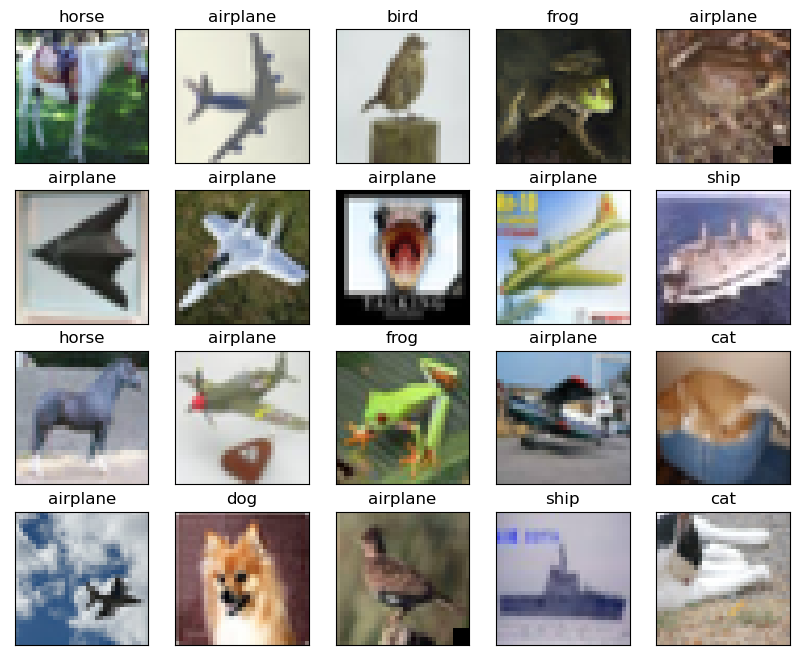

In [28]:
# Visualize triggered images
import matplotlib.pyplot as plt

# Define the classes
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

# Select a random subset of images to display
num_images = 20
indices = np.random.choice(num_poisoned_train_20, size=num_images, replace=False)

# Replace the first 10 random images with triggered images
images = x_train_20[indices]
labels = y_train_20[indices]

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    # Convert the image to a 8-bit unsigned integer
    image = (images[i] * 255).astype(np.uint8)
    
    # Display the image
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(classes[np.where(labels==1)[1][i]]) # here change one-hot encoding back to categorical

plt.show()

## VGG-16 Model

In [29]:
##################################### VGG-16 Model #########################################

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Clean VGG-16 Model

In [30]:
## Clean Data Training & Clean Data Test ##
# Define the VGG-16 model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
vgg_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
# Train the model
vgg_model.fit(
    x_train_clean, y_train_clean,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 9s 20ms/step - loss: 2.3020 - accuracy: 0.1054 - val_loss: 2.2954 - val_accuracy: 0.1652
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 2.1320 - accuracy: 0.2005 - val_loss: 2.0074 - val_accuracy: 0.2460
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 1.9020 - accuracy: 0.2860 - val_loss: 1.7901 - val_accuracy: 0.3120
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.6490 - accuracy: 0.3808 - val_loss: 1.5623 - val_accuracy: 0.4212
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 1.4351 - accuracy: 0.4662 - val_loss: 1.3194 - val_accuracy: 0.5181
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 1.2135 - accuracy: 0.5566 - val_loss: 1.2260 - val_accuracy: 0.5571
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 1.0070 - accuracy: 0.6387 - val_loss: 1.0424 - val_accuracy: 0.6265

In [32]:
# Evaluate the model (loss, accuracy)
vgg_result_list_clean = vgg_model.evaluate(x_test_clean, y_test_clean)
final_vgg_result_clean = [ '%.4f' % elem for elem in vgg_result_list_clean ]
final_vgg_result_clean ## Result: 1.6236 Loss, 81.63% ACC

313/313 [==============================] - 1s 3ms/step - loss: 1.2565 - accuracy: 0.8072


['1.2565', '0.8072']

### 5% VGG-16 Model

In [33]:
## 5% Triggered Data Training & Test ##
# Define the VGG-16 model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
vgg_model_5 = Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg_model_5.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Train the model
vgg_model_5.fit(
    x_train_5, y_train_5,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 2.2934 - accuracy: 0.1447 - val_loss: 2.3127 - val_accuracy: 0.1000
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 2.2507 - accuracy: 0.1526 - val_loss: 2.1307 - val_accuracy: 0.1952
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 2.0268 - accuracy: 0.2414 - val_loss: 1.9485 - val_accuracy: 0.2730
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.8223 - accuracy: 0.3121 - val_loss: 1.7362 - val_accuracy: 0.3337
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 1.6071 - accuracy: 0.3985 - val_loss: 1.4274 - val_accuracy: 0.4649
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 1.3069 - accuracy: 0.5221 - val_loss: 1.2279 - val_accuracy: 0.5443
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 1.0695 - accuracy: 0.6117 - val_loss: 1.0669 - val_accuracy: 0.6147

In [35]:
# Evaluate the model (loss, accuracy)
vgg_result_list_5 = vgg_model_5.evaluate(x_test_clean, y_test_clean)
final_vgg_result_5 = [ '%.4f' % elem for elem in vgg_result_list_5 ]
vgg_result_list_5_asr = vgg_model_5.evaluate(x_test_5[indices_test_5], y_test_5[indices_test_5])
final_vgg_result_5_asr = round(vgg_result_list_5_asr[1], 4)
print(final_vgg_result_5[0], final_vgg_result_5[1], final_vgg_result_5_asr) ## Result: 1.3292 Loss, 79.51% ACC, 95.20% ASR

16/16 [==============================] - 0s 9ms/step - loss: 0.3499 - accuracy: 0.9760
1.4184 0.8009 0.976


### 10% VGG-16 Model

In [36]:
## 10% Triggered Data Training & Test ##
# Define the VGG-16 model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
vgg_model_10 = Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg_model_10.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Train the model
vgg_model_10.fit(
    x_train_10, y_train_10,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 2.2683 - accuracy: 0.1897 - val_loss: 2.3357 - val_accuracy: 0.1000
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 2.2201 - accuracy: 0.1950 - val_loss: 2.1227 - val_accuracy: 0.1695
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 2.0205 - accuracy: 0.2421 - val_loss: 1.9528 - val_accuracy: 0.2790
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.8434 - accuracy: 0.2996 - val_loss: 1.7185 - val_accuracy: 0.3540
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 1.6074 - accuracy: 0.3987 - val_loss: 1.5043 - val_accuracy: 0.4440
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 1.2469 - accuracy: 0.5416 - val_loss: 1.2890 - val_accuracy: 0.5319
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 1.0238 - accuracy: 0.6277 - val_loss: 1.0531 - val_accuracy: 0.6259

In [38]:
# Evaluate the model (loss, accuracy)
vgg_result_list_10 = vgg_model_10.evaluate(x_test_clean, y_test_clean)
final_vgg_result_10 = [ '%.4f' % elem for elem in vgg_result_list_10 ]
vgg_result_list_10_asr = vgg_model_10.evaluate(x_test_10[indices_test_10], y_test_10[indices_test_10])
final_vgg_result_10_asr = round(vgg_result_list_10_asr[1], 4)
print(final_vgg_result_10[0], final_vgg_result_10[1], final_vgg_result_10_asr) ## Result: 1.3831 Loss, 78.42% ACC, 95.20% ASR

32/32 [==============================] - 0s 6ms/step - loss: 0.1519 - accuracy: 0.9870
1.3085 0.7793 0.987


### 15% VGG-16 Model

In [39]:
## 15% Triggered Data Training & Test ##
# Define the VGG-16 model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
vgg_model_15 = Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg_model_15.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Train the model
vgg_model_15.fit(
    x_train_15, y_train_15,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 2.2306 - accuracy: 0.2344 - val_loss: 2.3580 - val_accuracy: 0.1000
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 2.2260 - accuracy: 0.2348 - val_loss: 2.3582 - val_accuracy: 0.1000
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 2.1209 - accuracy: 0.2379 - val_loss: 2.1501 - val_accuracy: 0.1500
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.9173 - accuracy: 0.2651 - val_loss: 1.9079 - val_accuracy: 0.2183
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 1.5421 - accuracy: 0.4105 - val_loss: 1.6163 - val_accuracy: 0.3790
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 1.2856 - accuracy: 0.5170 - val_loss: 1.3197 - val_accuracy: 0.5085
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 1.0697 - accuracy: 0.6037 - val_loss: 1.1495 - val_accuracy: 0.5831

In [41]:
# Evaluate the model (loss, accuracy)
vgg_result_list_15 = vgg_model_15.evaluate(x_test_clean, y_test_clean)
final_vgg_result_15 = [ '%.4f' % elem for elem in vgg_result_list_15 ]
vgg_result_list_15_asr = vgg_model_15.evaluate(x_test_15[indices_test_15], y_test_15[indices_test_15])
final_vgg_result_15_asr = round(vgg_result_list_15_asr[1], 4)
print(final_vgg_result_15[0], final_vgg_result_15[1], final_vgg_result_15_asr) ## Result: 1.4310 Loss, 78.56% ACC, 97.00% ASR

47/47 [==============================] - 0s 5ms/step - loss: 0.0599 - accuracy: 0.9947
1.4164 0.7916 0.9947


### 20% VGG-16 Model

In [42]:
## 20% Triggered Data Training & Test ##
# Define the VGG-16 model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
vgg_model_20 = Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg_model_20.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Train the model
vgg_model_20.fit(
    x_train_20, y_train_20,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 2.1814 - accuracy: 0.2799 - val_loss: 2.3890 - val_accuracy: 0.1000
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 2.1742 - accuracy: 0.2805 - val_loss: 2.3957 - val_accuracy: 0.1000
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 2.0722 - accuracy: 0.2791 - val_loss: 2.2094 - val_accuracy: 0.1000
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.8760 - accuracy: 0.2923 - val_loss: 1.9883 - val_accuracy: 0.2194
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 1.4571 - accuracy: 0.4411 - val_loss: 1.6387 - val_accuracy: 0.3597
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 1.2182 - accuracy: 0.5385 - val_loss: 1.5284 - val_accuracy: 0.4382
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 1.0502 - accuracy: 0.6120 - val_loss: 1.2854 - val_accuracy: 0.5342

In [44]:
# Evaluate the model (loss, accuracy)
vgg_result_list_20 = vgg_model_20.evaluate(x_test_clean, y_test_clean)
final_vgg_result_20 = [ '%.4f' % elem for elem in vgg_result_list_20 ]
vgg_result_list_20_asr = vgg_model_20.evaluate(x_test_20[indices_test_20], y_test_20[indices_test_20])
final_vgg_result_20_asr = round(vgg_result_list_20_asr[1], 4)
print(final_vgg_result_20[0], final_vgg_result_20[1], final_vgg_result_20_asr) ## Result: 1.3558 Loss, 76.76% ACC, 97.25% ASR

63/63 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9960
1.3163 0.7816 0.996


## ResNet Model

In [45]:
##################################### ResNet Model #########################################
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Define the ResNet block
def resnet_block(inputs, filters, downsample=False):
    strides = (2, 2) if downsample else (1, 1) 
    x = Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    if downsample:
        inputs = Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        inputs = BatchNormalization()(inputs)
    x = Add()([inputs, x])
    x = ReLU()(x)
    return x

### Clean ResNet Model

In [46]:
# Define the Clean ResNet model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)
x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)
x = AveragePooling2D(pool_size=4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
resnet_model = Model(inputs=inputs, outputs=outputs)

In [47]:
## Clean Data Training & Clean Data Test ##
# Compile the model
resnet_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
# Train the model
resnet_model.fit(
    x_train_clean, y_train_clean,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 15s 36ms/step - loss: 1.2444 - accuracy: 0.5622 - val_loss: 1.3971 - val_accuracy: 0.5132
Epoch 2/50
391/391 [==============================] - 14s 35ms/step - loss: 0.7270 - accuracy: 0.7449 - val_loss: 1.0758 - val_accuracy: 0.6515
Epoch 3/50
391/391 [==============================] - 14s 35ms/step - loss: 0.5528 - accuracy: 0.8076 - val_loss: 0.7463 - val_accuracy: 0.7433
Epoch 4/50
391/391 [==============================] - 14s 35ms/step - loss: 0.4356 - accuracy: 0.8473 - val_loss: 1.8066 - val_accuracy: 0.5701
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.3421 - accuracy: 0.8798 - val_loss: 1.3878 - val_accuracy: 0.6502
Epoch 6/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2637 - accuracy: 0.9084 - val_loss: 1.0752 - val_accuracy: 0.6982
Epoch 7/50
391/391 [==============================] - 14s 35ms/step - loss: 0.1935 - accuracy: 0.9336 - val_loss: 0.8117 - val_accuracy:

In [49]:
# Evaluate the model (loss, accuracy)
resnet_result_list_clean = resnet_model.evaluate(x_test_clean, y_test_clean)
final_resnet_result_clean = [ '%.4f' % elem for elem in resnet_result_list_clean ]
final_resnet_result_clean ## Result: 0.9452 Loss, 84.69% ACC

313/313 [==============================] - 1s 3ms/step - loss: 1.2983 - accuracy: 0.8143


['1.2983', '0.8143']

### 5% ResNet Model

In [50]:
# Define the 5% Triggered ResNet model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)
x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)
x = AveragePooling2D(pool_size=4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
resnet_model_5 = Model(inputs=inputs, outputs=outputs)

In [51]:
## 5% Triggered Data Training & Test ##
# Compile the model
resnet_model_5.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
# Train the model
resnet_model_5.fit(
    x_train_5, y_train_5,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 15s 36ms/step - loss: 1.1959 - accuracy: 0.5757 - val_loss: 1.9320 - val_accuracy: 0.4033
Epoch 2/50
391/391 [==============================] - 14s 36ms/step - loss: 0.6967 - accuracy: 0.7558 - val_loss: 0.8744 - val_accuracy: 0.7115
Epoch 3/50
391/391 [==============================] - 14s 35ms/step - loss: 0.5186 - accuracy: 0.8199 - val_loss: 0.7154 - val_accuracy: 0.7554
Epoch 4/50
391/391 [==============================] - 14s 35ms/step - loss: 0.4049 - accuracy: 0.8602 - val_loss: 0.6139 - val_accuracy: 0.7890
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.3147 - accuracy: 0.8906 - val_loss: 0.7713 - val_accuracy: 0.7624
Epoch 6/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2325 - accuracy: 0.9198 - val_loss: 0.8342 - val_accuracy: 0.7583
Epoch 7/50
391/391 [==============================] - 14s 36ms/step - loss: 0.1739 - accuracy: 0.9395 - val_loss: 0.6405 - val_accuracy:

In [53]:
# Evaluate the model (loss, accuracy)
resnet_result_list_5 = resnet_model_5.evaluate(x_test_clean, y_test_clean)
final_resnet_result_5 = [ '%.4f' % elem for elem in resnet_result_list_5 ]
resnet_result_list_5_asr = resnet_model_5.evaluate(x_test_5[indices_test_5], y_test_5[indices_test_5])
final_resnet_result_5_asr = round(resnet_result_list_5_asr[1], 4)
print(final_resnet_result_5[0], final_resnet_result_5[1], final_resnet_result_5_asr) ## Result: 1.2183 Loss, 81.39% ACC, 97.20% ASR

16/16 [==============================] - 0s 4ms/step - loss: 0.2242 - accuracy: 0.9880
0.9928 0.8377 0.988


### 10% ResNet Model

In [54]:
# Define the 10% Triggered ResNet model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)
x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)
x = AveragePooling2D(pool_size=4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
resnet_model_10 = Model(inputs=inputs, outputs=outputs)

In [55]:
## 10% Triggered Data Training & Test ##
# Compile the model
resnet_model_10.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
# Train the model
resnet_model_10.fit(
    x_train_10, y_train_10,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 15s 36ms/step - loss: 1.1277 - accuracy: 0.6010 - val_loss: 1.5950 - val_accuracy: 0.4934
Epoch 2/50
391/391 [==============================] - 14s 35ms/step - loss: 0.6668 - accuracy: 0.7681 - val_loss: 1.0092 - val_accuracy: 0.6707
Epoch 3/50
391/391 [==============================] - 14s 35ms/step - loss: 0.4987 - accuracy: 0.8262 - val_loss: 0.7859 - val_accuracy: 0.7414
Epoch 4/50
391/391 [==============================] - 14s 35ms/step - loss: 0.3899 - accuracy: 0.8638 - val_loss: 0.6322 - val_accuracy: 0.7842
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2983 - accuracy: 0.8967 - val_loss: 1.0428 - val_accuracy: 0.7057
Epoch 6/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2233 - accuracy: 0.9236 - val_loss: 1.0470 - val_accuracy: 0.7114
Epoch 7/50
391/391 [==============================] - 14s 35ms/step - loss: 0.1596 - accuracy: 0.9452 - val_loss: 1.1458 - val_accuracy:

In [57]:
# Evaluate the model (loss, accuracy)
resnet_result_list_10 = resnet_model_10.evaluate(x_test_clean, y_test_clean)
final_resnet_result_10 = [ '%.4f' % elem for elem in resnet_result_list_10 ]
resnet_result_list_10_asr = resnet_model_10.evaluate(x_test_10[indices_test_10], y_test_10[indices_test_10])
final_resnet_result_10_asr = round(resnet_result_list_10_asr[1], 4)
print(final_resnet_result_10[0], final_resnet_result_10[1], final_resnet_result_10_asr) ## Result: 1.0989 Loss, 81.37% ACC, 97.5% ASR

32/32 [==============================] - 0s 4ms/step - loss: 0.0620 - accuracy: 0.9940
1.4086 0.8067 0.994


### 15% ResNet Model

In [58]:
# Define the 15% Triggered ResNet model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)
x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)
x = AveragePooling2D(pool_size=4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
resnet_model_15 = Model(inputs=inputs, outputs=outputs)

In [59]:
## 15% Triggered Data Training & Test ##
# Compile the model
resnet_model_15.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
# Train the model
resnet_model_15.fit(
    x_train_15, y_train_15,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 15s 36ms/step - loss: 1.1121 - accuracy: 0.6079 - val_loss: 1.7064 - val_accuracy: 0.4318
Epoch 2/50
391/391 [==============================] - 14s 35ms/step - loss: 0.6485 - accuracy: 0.7713 - val_loss: 1.2851 - val_accuracy: 0.5694
Epoch 3/50
391/391 [==============================] - 14s 35ms/step - loss: 0.4896 - accuracy: 0.8290 - val_loss: 1.1643 - val_accuracy: 0.6511
Epoch 4/50
391/391 [==============================] - 14s 35ms/step - loss: 0.3898 - accuracy: 0.8641 - val_loss: 1.1878 - val_accuracy: 0.6685
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2985 - accuracy: 0.8966 - val_loss: 0.9519 - val_accuracy: 0.7443
Epoch 6/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2295 - accuracy: 0.9211 - val_loss: 0.7496 - val_accuracy: 0.7825
Epoch 7/50
391/391 [==============================] - 14s 35ms/step - loss: 0.1649 - accuracy: 0.9428 - val_loss: 0.8695 - val_accuracy:

In [61]:
# Evaluate the model (loss, accuracy)
resnet_result_list_15 = resnet_model_15.evaluate(x_test_clean, y_test_clean)
final_resnet_result_15 = [ '%.4f' % elem for elem in resnet_result_list_15 ]
resnet_result_list_15_asr = resnet_model_15.evaluate(x_test_15[indices_test_15], y_test_15[indices_test_15])
final_resnet_result_15_asr = round(resnet_result_list_15_asr[1], 4)
print(final_resnet_result_15[0], final_resnet_result_15[1], final_resnet_result_15_asr) ## Result: 1.2170 Loss, 79.67% ACC, 97.47% ASR

47/47 [==============================] - 0s 4ms/step - loss: 0.0870 - accuracy: 0.9940
1.6998 0.7746 0.994


### 20% ResNet Model

In [62]:
# Define the 20% Triggered ResNet model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)
x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)
x = AveragePooling2D(pool_size=4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
resnet_model_20 = Model(inputs=inputs, outputs=outputs)

In [63]:
## 20% Triggered Data Training & Test ##
# Compile the model
resnet_model_20.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
# Train the model
resnet_model_20.fit(
    x_train_20, y_train_20,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_clean, y_test_clean)
)

Epoch 1/50
391/391 [==============================] - 15s 36ms/step - loss: 1.0269 - accuracy: 0.6357 - val_loss: 1.8365 - val_accuracy: 0.3899
Epoch 2/50
391/391 [==============================] - 14s 35ms/step - loss: 0.6066 - accuracy: 0.7880 - val_loss: 1.0533 - val_accuracy: 0.6654
Epoch 3/50
391/391 [==============================] - 14s 35ms/step - loss: 0.4776 - accuracy: 0.8342 - val_loss: 0.8486 - val_accuracy: 0.7265
Epoch 4/50
391/391 [==============================] - 14s 35ms/step - loss: 0.3726 - accuracy: 0.8709 - val_loss: 0.9932 - val_accuracy: 0.7060
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2962 - accuracy: 0.8964 - val_loss: 1.0060 - val_accuracy: 0.7152
Epoch 6/50
391/391 [==============================] - 14s 35ms/step - loss: 0.2219 - accuracy: 0.9236 - val_loss: 0.7325 - val_accuracy: 0.7755
Epoch 7/50
391/391 [==============================] - 14s 35ms/step - loss: 0.1601 - accuracy: 0.9459 - val_loss: 1.0025 - val_accuracy:

In [65]:
# Evaluate the model (loss, accuracy)
resnet_result_list_20 = resnet_model_20.evaluate(x_test_clean, y_test_clean)
final_resnet_result_20 = [ '%.4f' % elem for elem in resnet_result_list_20 ]
resnet_result_list_20_asr = resnet_model_20.evaluate(x_test_20[indices_test_20], y_test_20[indices_test_20])
final_resnet_result_20_asr = round(resnet_result_list_20_asr[1], 4)
print(final_resnet_result_20[0], final_resnet_result_20[1], final_resnet_result_20_asr) ## Result: 1.6194 Loss, 76.86% ACC, 96.95% ASR

63/63 [==============================] - 0s 3ms/step - loss: 0.0539 - accuracy: 0.9970
1.0485 0.8343 0.997


## Model Comparison

In [66]:
# Import pandas library
import pandas as pd
  
# initialize list of lists
data_loss = [[final_cnn_result_clean[0], final_vgg_result_clean[0], final_resnet_result_clean[0]], 
             [final_cnn_result_5[0], final_vgg_result_5[0], final_resnet_result_5[0]], 
             [final_cnn_result_10[0], final_vgg_result_10[0], final_resnet_result_10[0]],
             [final_cnn_result_15[0], final_vgg_result_15[0], final_resnet_result_15[0]], 
             [final_cnn_result_20[0], final_vgg_result_20[0], final_resnet_result_20[0]]]
  
# Create the pandas DataFrame
df_loss = pd.DataFrame(data_loss, columns=['CNN', 'VGG', 'ResNet'])
  
# print dataframe.
df_loss

,CNN,VGG,ResNet
0,3.3629,1.2565,1.2983
1,3.0752,1.4184,0.9928
2,3.2274,1.3085,1.4086
3,3.3020,1.4164,1.6998
4,3.8270,1.3163,1.0485


In [67]:
# initialize list of lists
data_acc = [[final_cnn_result_clean[1], final_vgg_result_clean[1], final_resnet_result_clean[1]], 
             [final_cnn_result_5[1], final_vgg_result_5[1], final_resnet_result_5[1]], 
             [final_cnn_result_10[1], final_vgg_result_10[1], final_resnet_result_10[1]],
             [final_cnn_result_15[1], final_vgg_result_15[1], final_resnet_result_15[1]], 
             [final_cnn_result_20[1], final_vgg_result_20[1], final_resnet_result_20[1]]]
  
# Create the pandas DataFrame
df_acc = pd.DataFrame(data_acc, columns=['CNN', 'VGG', 'ResNet'])
  
# print dataframe.
df_acc

,CNN,VGG,ResNet
0,0.7230,0.8072,0.8143
1,0.7282,0.8009,0.8377
2,0.7227,0.7793,0.8067
3,0.7111,0.7916,0.7746
4,0.6883,0.7816,0.8343


In [68]:
# initialize list of lists
data_asr = [[final_cnn_result_5_asr, final_vgg_result_5_asr, final_resnet_result_5_asr], 
             [final_cnn_result_10_asr, final_vgg_result_10_asr, final_resnet_result_10_asr],
             [final_cnn_result_15_asr, final_vgg_result_15_asr, final_resnet_result_15_asr], 
             [final_cnn_result_20_asr, final_vgg_result_20_asr, final_resnet_result_20_asr]]
  
# Create the pandas DataFrame
df_asr = pd.DataFrame(data_asr, columns=['CNN', 'VGG', 'ResNet'])
  
# print dataframe.
df_asr

,CNN,VGG,ResNet
0,0.934,0.9760,0.988
1,0.974,0.9870,0.994
2,0.986,0.9947,0.994
3,0.990,0.9960,0.997
